In [1]:
import sys

from src.dataset import X_TIME, TIME_STEP
from src.models import optimal_model_builder_ch_2_11

PWD = '../../..'
sys.path.append(PWD)

import pickle
import numpy as np

import tensorflow as tf

tf.get_logger().setLevel('ERROR')

from sklearn.model_selection import train_test_split

from src.cfd import CFD
from src.gauss_hist import get_gauss_stats
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results, \
    gaussian_kernel

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'

PRINT_PCOV = False

N_BASELINE = 8

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

# Utils

In [4]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [5]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=LR, train=False, n_epochs=N_EPOCHS, verbose=1,
                batch_size=BATCH_SIZE, lr_patience=4, es_patience=20, es_min_delta=ES_MIN_DELTA,
                loss_weights=LOSS_WEIGHT):
    return _base_train_model(model, name, 'many_channels_tests/trained_on_all', X_train, y_train, X_val, y_val, lr,
                             train, n_epochs, verbose, batch_size, lr_patience, es_patience, es_min_delta, loss_weights,
                             root=PWD + '/data')

# Load optimal CFD thresholds

In [6]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.180
(1, 11): 0.185
(2,  2): 0.220
(2, 11): 0.145
(3,  2): 0.130
(3, 11): 0.175


# Train the network

In [7]:
train_X_list, train_y_list, test_X_list, test_y_list = [], [], [], []
for (plane, channel), (X, y) in dataset.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    train_X_list.append(X_train)
    train_y_list.append(Y_heatmap_train)
    test_X_list.append(X_test)
    test_y_list.append(Y_heatmap_test)

X_train_all = np.concatenate(train_X_list)
y_train_all = np.concatenate(train_y_list)
X_test_all = np.concatenate(test_X_list)
y_test_all = np.concatenate(test_y_list)

X_train_all.shape, y_train_all.shape, X_test_all.shape, y_test_all.shape

((100375, 24), (100375, 24), (33461, 24), (33461, 24))

In [8]:
model = optimal_model_builder_ch_2_11()
history = train_model(model, "optimal", X_train=X_train_all, y_train=y_train_all, X_val=X_test_all, y_val=y_test_all,
                      train=False)

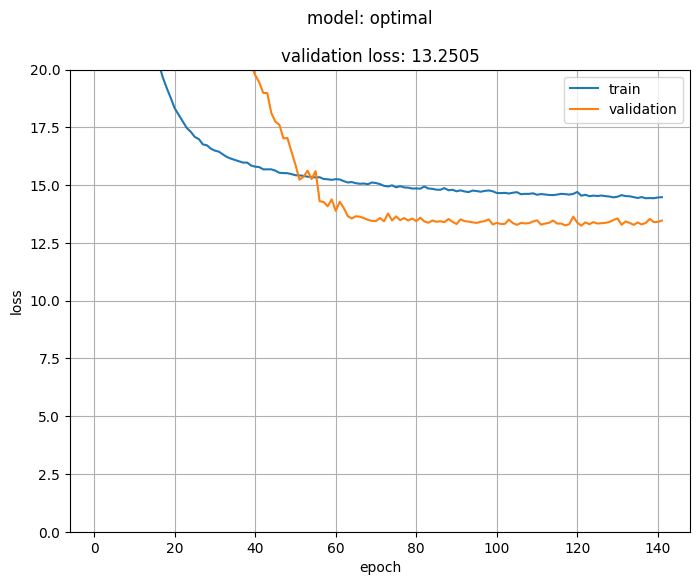

In [9]:
plot_history(history, f'model: optimal', ymax=20)

# Test

Processing p=1, ch=2...
2/2 [==============================] - 2s 22ms/step
       CFD: 75.85 ps
   optimal: 69.60 ps (improvement: 8.23 %)
Processing p=1, ch=11...
2/2 [==============================] - 0s 23ms/step
       CFD: 88.09 ps
   optimal: 80.86 ps (improvement: 8.21 %)
Processing p=2, ch=2...
2/2 [==============================] - 0s 21ms/step
       CFD: 79.88 ps
   optimal: 70.47 ps (improvement: 11.77 %)
Processing p=2, ch=11...
2/2 [==============================] - 0s 22ms/step
       CFD: 90.59 ps
   optimal: 85.71 ps (improvement: 5.39 %)
Processing p=3, ch=2...
2/2 [==============================] - 0s 102ms/step
       CFD: 85.99 ps
   optimal: 78.27 ps (improvement: 8.98 %)
Processing p=3, ch=11...
2/2 [==============================] - 0s 101ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 116.78 ps
   optimal: 99.09 ps (improvement: 15.16 %)


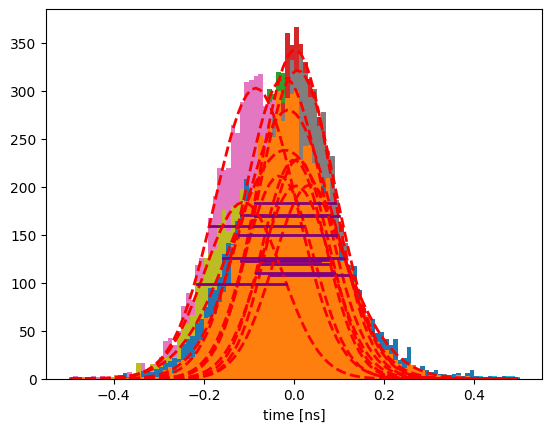

In [10]:
improvements = {}
for (plane, channel), (all_X, all_y) in dataset.items():
    print(f'Processing p={plane}, ch={channel}...')

    _, X_test, _, y_test = train_test_split(all_X, all_y, test_size=0.25, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(X_TIME, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

    y_pred_model = model_predict(model, X_test)
    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

    compare_results([std_model], ["optimal"], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [11]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  75.85 ps, NN:  69.60 ( 8.23 %)
(1, 11) CFD:  88.09 ps, NN:  80.86 ( 8.21 %)
(2,  2) CFD:  79.88 ps, NN:  70.47 (11.77 %)
(2, 11) CFD:  90.59 ps, NN:  85.71 ( 5.39 %)
(3,  2) CFD:  85.99 ps, NN:  78.27 ( 8.98 %)
(3, 11) CFD: 116.78 ps, NN:  99.09 (15.16 %)
